### Setting the feelpp environment


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using device: cpu
torch loaded; device is cpu
>> load network /workspaces/2024-stage-feelpp-scimba/networks/test.pth
network was not loaded from file: training needed
epoch     0: current loss = 7.71e+03
epoch     0: best loss = 7.71e+03
epoch     1: best loss = 3.63e+03
epoch     2: best loss = 7.52e+02
epoch     3: best loss = 3.12e+02
epoch     6: best loss = 7.28e-01
epoch    23: best loss = 1.30e-02
epoch    64: best loss = 8.43e-03
epoch    83: best loss = 6.36e-03
epoch    89: best loss = 4.61e-03
epoch    99: current loss = 2.66e-02
load network: /workspaces/2024-stage-feelpp-scimba/networks/test.pth
jsbdbshd
network loaded


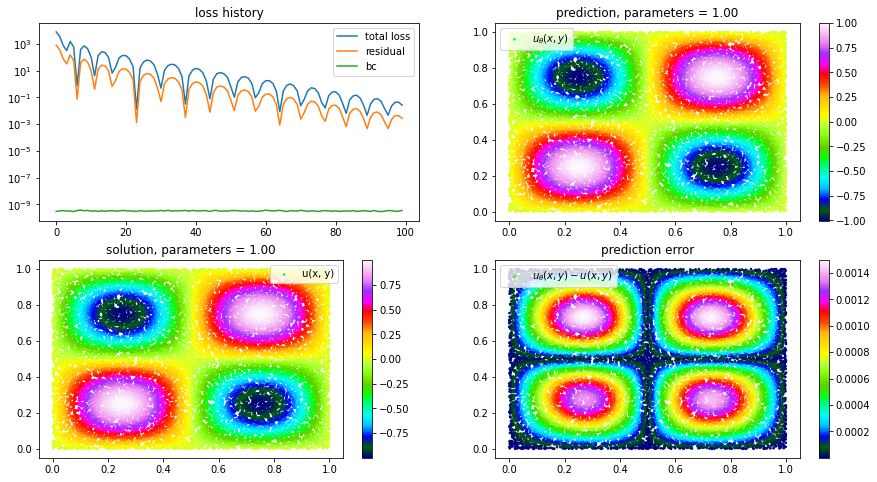

-0.0005*x*y - 0.0001*x*y*y + 0.0028*x + 0.0002*x*x*y - 0.0025*x*x - 0.0001*x*x*x + 0.003*y - 0.0024*y*y - 0.0001*y*y*y + 1.00024468763787


In [1]:
import torch
import numpy as np
import sympy as sp
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from tools.scimba_pinns import Run_laplacian2D, Poisson_2D, PoissonDisk2D
from scimba.equations import domain


xdomain = domain.SpaceDomain(2, domain.SquareDomain(2, [[0.0, 1.0], [0.0, 1.0]]))
pde = Poisson_2D(xdomain)
network, pde = Run_laplacian2D(pde)
# Extract solution function u
u_scimba = network.forward

# Step 1: Generate a grid of (x, y) points and evaluate the network

# Define a grid of points
x_vals = np.linspace(0, 1, 50)
y_vals = np.linspace(0, 1, 50)
xx, yy = np.meshgrid(x_vals, y_vals)
grid_points = np.vstack([xx.ravel(), yy.ravel()]).T

# Convert to tensor and evaluate the neural network
coordinates_tensor = torch.tensor(grid_points, dtype=torch.double)
mu_value = 1
mu = torch.full((coordinates_tensor.size(0), 1), mu_value, dtype=torch.double)

with torch.no_grad():  # Ensure no gradient computations
    solution_tensor = u_scimba(coordinates_tensor, mu).numpy()

# Step 2: Perform symbolic regression using polynomial regression

# Prepare the polynomial features
poly = PolynomialFeatures(degree=3)  # Degree 3 for cubic polynomials
X_poly = poly.fit_transform(grid_points)

# Fit a linear regression model to the polynomial features
model = LinearRegression()
model.fit(X_poly, solution_tensor.ravel())

# Extract the polynomial coefficients
coefficients = model.coef_
intercept = model.intercept_

# Step 3: Convert the fitted polynomial to a symbolic expression

# Define symbolic variables
x, y = sp.symbols('x y')
poly_feature_names = poly.get_feature_names(input_features=['x', 'y'])

symbolic_expr = sp.sympify(intercept)
for coef, feature in zip(coefficients, poly_feature_names):
    if coef != 0:
        coef = round(coef, 4)
        terms = feature.split()
        expr_terms = []
        for term in terms:
            if term == 'x':
                expr_terms.append(x)
            elif term == 'y':
                expr_terms.append(y)
            else:
                expr_terms.append(sp.symbols(term))
        symbolic_expr += coef * sp.Mul(*expr_terms)

# Print the symbolic expression
expr_str = str(symbolic_expr)
expr_str = expr_str.replace('x^2', 'x*x')
expr_str = expr_str.replace('y^2', 'y*y')
expr_str = expr_str.replace('x^3', 'x*x*x')
expr_str = expr_str.replace('y^3', 'y*y*y')

print(expr_str)



In [2]:
from tools.GmeshRead import mesh2d
import pyvista as pv
import pandas as pd
import torch

# File path to the .case file
file_path = 'feelppdb/feelpp_cfpde/np_1/cfpdes-2d-p1.exports/Export.case'

# Read the .case file using PyVista
data = pv.read(file_path)

# Iterate over each block in the dataset to find coordinates
coordinates = None
for i, block in enumerate(data):
    if block is None:
        continue
    # Extract the mesh points (coordinates)
    coordinates = block.points
    solution = 'cfpdes.poisson.u'
    solution_expression = block.point_data[solution]

    df = pd.DataFrame(block.point_data)
    print(df.head())
# Considering only 2d problems:
num_features = coordinates.shape[1]
if num_features > 2:
    coordinates = coordinates[:, :2]

print(f"Number of points: {len(coordinates)}")          
print("\nNodes:"  , coordinates)

mesh = "feelppdb/feelpp_cfpde/np_1/omega-2.msh"
my_mesh = mesh2d(mesh)
my_mesh.read_mesh()
print("Number of nodes:", my_mesh.Nnodes)
print("Nodes coordinates:", my_mesh.Nodes)
for i in range(517):
    print(f"Node {i} = {coordinates[i], my_mesh.Nodes[i]}")

"""
print('difference = ', coordinates - my_mesh.Nodes)
feel_solution = block.point_data['cfpdes.poisson.u']
print("\nFeel++ solution 'cfpdes.poisson.u':")
print(feel_solution) 
"""

                          0
0  cfpdes.expr.grad_u_exact
1           cfpdes.expr.rhs
2       cfpdes.expr.u_exact
3          cfpdes.poisson.u
Number of points: 7554

Nodes: [[0.32009158 0.0112713 ]
 [0.33214724 0.01079619]
 [0.32754993 0.02345362]
 ...
 [0.01827418 0.2125    ]
 [0.29523468 0.991313  ]
 [0.52455205 0.01731404]]
Number of nodes: 7554
Nodes coordinates: [[0.         0.        ]
 [1.         0.        ]
 [1.         1.        ]
 ...
 [0.26312123 0.98359724]
 [0.00686967 0.24360511]
 [0.74218194 0.97133177]]
Node 0 = (pyvista_ndarray([0.32009158, 0.0112713 ], dtype=float32), array([0., 0.]))
Node 1 = (pyvista_ndarray([0.33214724, 0.01079619], dtype=float32), array([1., 0.]))
Node 2 = (pyvista_ndarray([0.32754993, 0.02345362], dtype=float32), array([1., 1.]))
Node 3 = (pyvista_ndarray([0.8271963, 0.0251195], dtype=float32), array([0., 1.]))
Node 4 = (pyvista_ndarray([0.8167246 , 0.01882553], dtype=float32), array([0.0125, 0.    ]))
Node 5 = (pyvista_ndarray([0.82932353, 0.0118

'\nprint(\'difference = \', coordinates - my_mesh.Nodes)\nfeel_solution = block.point_data[\'cfpdes.poisson.u\']\nprint("\nFeel++ solution \'cfpdes.poisson.u\':")\nprint(feel_solution) \n'

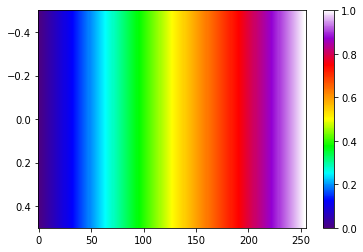

[ Starting Feel++ ] application feelpp_app version 0.1 date 2024-Jun-17
 . feelpp_app files are stored in /workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1
 .. logfiles :/workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/logs
Solving the laplacian problem for h = 0.05...
generate mesh omega-2.geo with h=0.05 and dimension=2
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.05 
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                                 |
+----------------------------------------------------------------------------------------------------

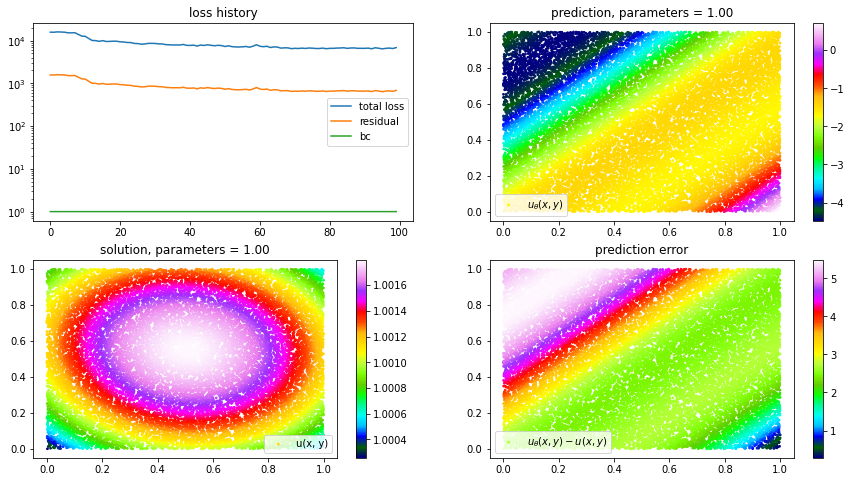

                          0
0  cfpdes.expr.grad_u_exact
1           cfpdes.expr.rhs
2       cfpdes.expr.u_exact
3          cfpdes.poisson.u
Number of features in coordinates: 3
Number of points: 517

Nodes: [[0.82477343 0.04606718]
 [0.8300841  0.10191753]
 [0.7806651  0.09123866]
 ...
 [0.8390992  0.3016979 ]
 [0.8367227  0.1427201 ]
 [0.7476512  0.5844005 ]]

Feel++ solution 'cfpdes.poisson.u':
[-2.55882740e-01 -5.23014128e-01 -5.31600416e-01  4.51528639e-01
  5.54935336e-01  2.73693860e-01  0.00000000e+00  2.99670160e-01
  2.41641000e-01 -2.30834827e-01 -2.98673511e-01  0.00000000e+00
 -5.33562183e-01 -2.16567665e-01 -2.62957275e-01 -2.98950762e-01
 -1.16792865e-01 -1.96071774e-01  2.09492356e-01 -2.40673989e-01
 -5.17238796e-01 -2.29681395e-02 -1.59088224e-01 -2.30080426e-01
  1.77676231e-02  7.04201043e-01  4.76363331e-01  4.27088797e-01
 -3.99901003e-01  6.02511168e-01 -1.92533553e-01 -3.79127443e-01
  2.35925078e-01  1.21274188e-01  1.42786294e-01  3.49430382e-01
  1.98928967e-0

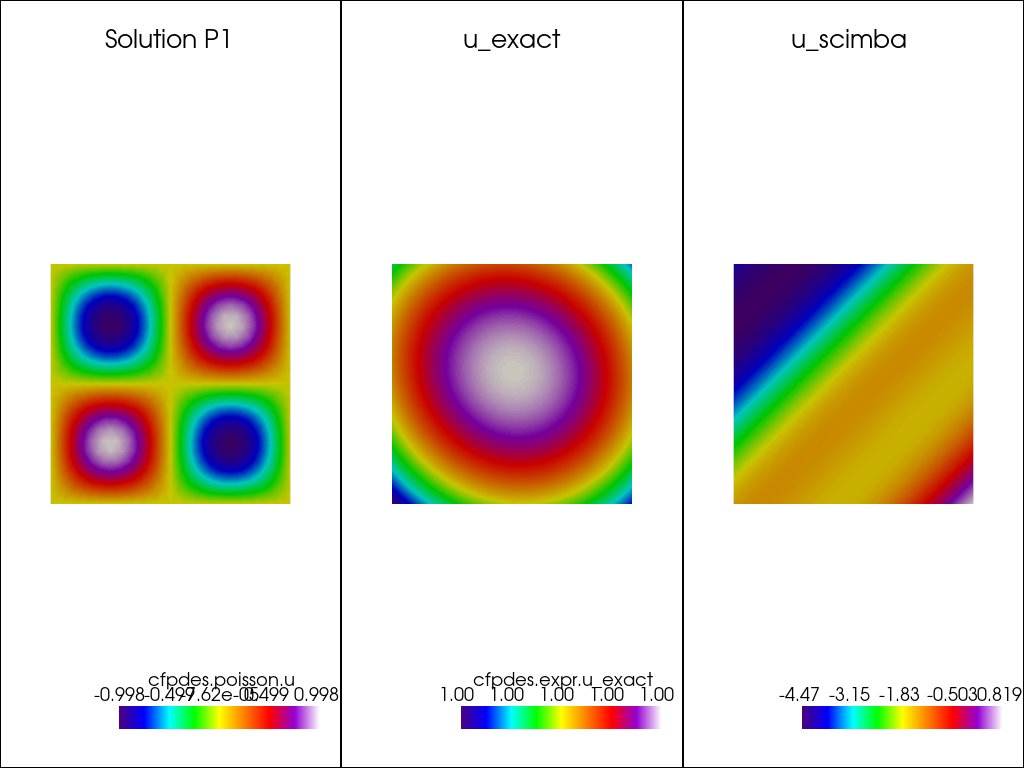

In [3]:
import sys
import feelpp
import feelpp.toolboxes.core as tb
from tools.Poisson import Poisson, runLaplacianPk, runConvergenceAnalysis, plot_convergence, custom_cmap

sys.argv = ["feelpp_app"]
e = feelpp.Environment(sys.argv,
                       opts=tb.toolboxes_options("coefficient-form-pdes", "cfpdes"),
                       config=feelpp.localRepository('feelpp_cfpde'))

# ------------------------------------------------------------------------- #
# Poisson problem
# - div (diff * grad (u)) = f    in Omega
#                     u   = g    in Gamma_D
# Omega = domain, either cube or ball
# Approx = lagrange Pk of order order
# mesh of size h

P = Poisson(dim = 2)
P(solver ='scimba', u_exact = expr_str)


### Examples with different parameters

Solving the laplacian problem for h = 0.05...
generate mesh omega-2.geo with h=0.05 and dimension=2
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.05 
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                                 |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| +-----------------------------------------------------------------------------------------+                                                            |
| | Environment                             

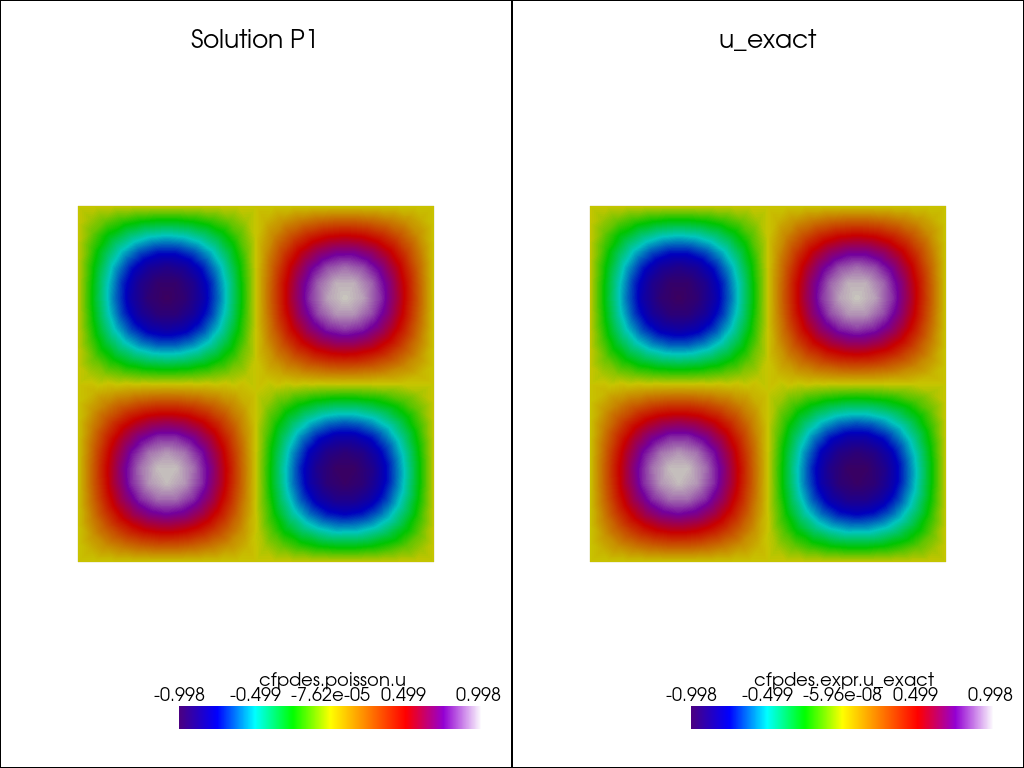

Solving the laplacian problem for h = 0.05...
generate mesh omega-2.geo with h=0.05 and dimension=2
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.05 
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                                 |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| +-----------------------------------------------------------------------------------------+                                                            |
| | Environment                             

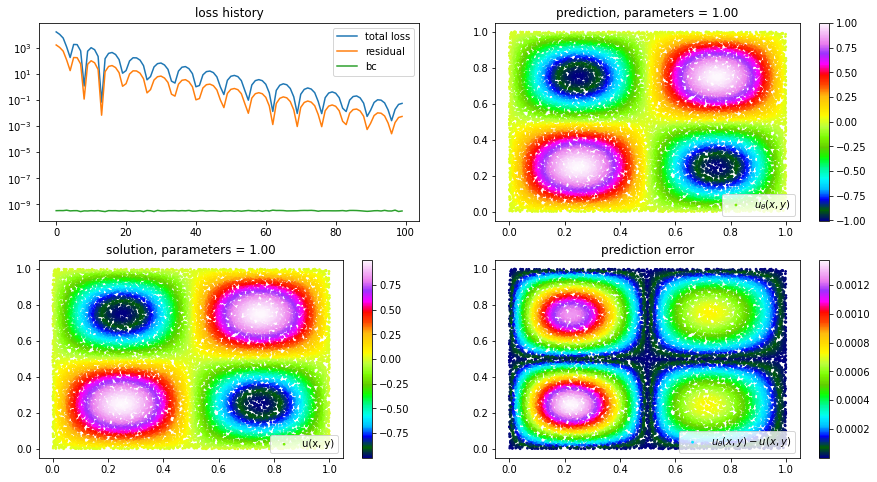

                          0
0  cfpdes.expr.grad_u_exact
1           cfpdes.expr.rhs
2       cfpdes.expr.u_exact
3          cfpdes.poisson.u
Number of features in coordinates: 3
Number of points: 517

Nodes: [[0.82477343 0.04606718]
 [0.8300841  0.10191753]
 [0.7806651  0.09123866]
 ...
 [0.8390992  0.3016979 ]
 [0.8367227  0.1427201 ]
 [0.7476512  0.5844005 ]]

Feel++ solution 'cfpdes.poisson.u':
[-2.55882740e-01 -5.23014128e-01 -5.31600416e-01  4.51528639e-01
  5.54935336e-01  2.73693860e-01  0.00000000e+00  2.99670160e-01
  2.41641000e-01 -2.30834827e-01 -2.98673511e-01  0.00000000e+00
 -5.33562183e-01 -2.16567665e-01 -2.62957275e-01 -2.98950762e-01
 -1.16792865e-01 -1.96071774e-01  2.09492356e-01 -2.40673989e-01
 -5.17238796e-01 -2.29681395e-02 -1.59088224e-01 -2.30080426e-01
  1.77676231e-02  7.04201043e-01  4.76363331e-01  4.27088797e-01
 -3.99901003e-01  6.02511168e-01 -1.92533553e-01 -3.79127443e-01
  2.35925078e-01  1.21274188e-01  1.42786294e-01  3.49430382e-01
  1.98928967e-0

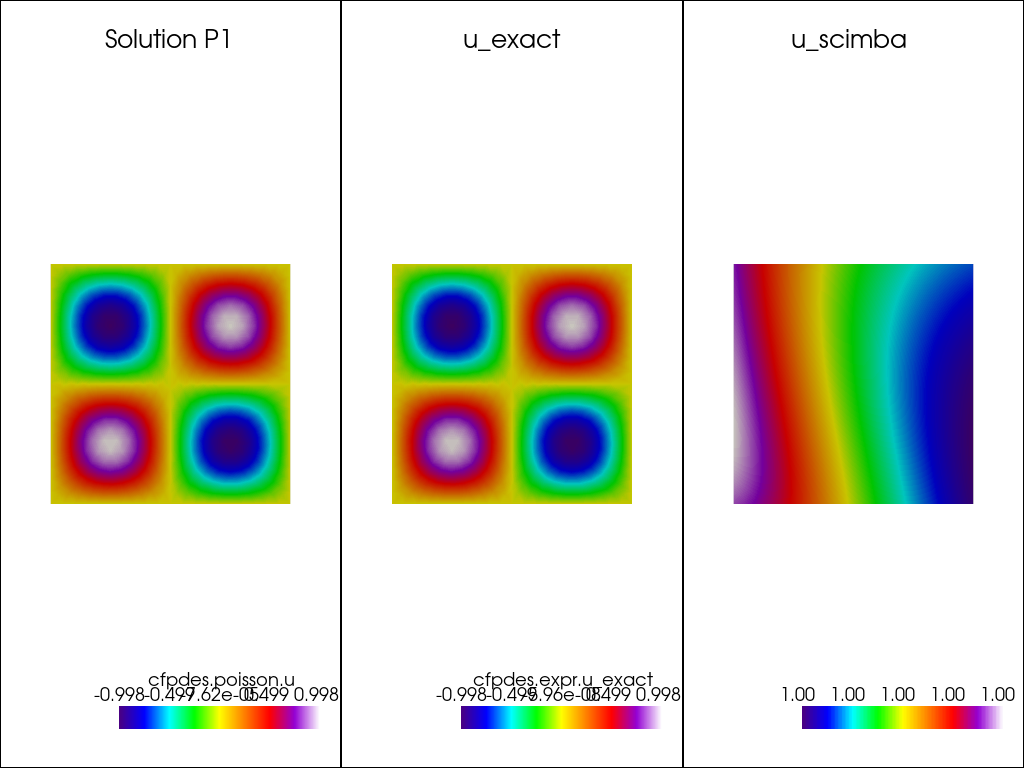

In [4]:

# for square domain

u_exact = 'sin(2*pi*x) * sin(2*pi*y)'
rhs = '8*pi*pi*sin(2*pi*x) * sin(2*pi*y)'

P(rhs=rhs, g='0', solver='feelpp', u_exact = u_exact)
P(rhs=rhs, g='0', solver ='scimba', u_exact = u_exact)


Solving the laplacian problem for h = 0.05...
generate mesh omega-2.geo with h=0.05 and dimension=2
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.05 
+------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                             |
+------------------------------------------------------------------------------------------------------------------------------------+
| +-----------------------------------------------------------------------------------------+                                        |
| | Environment                                                                             |                               

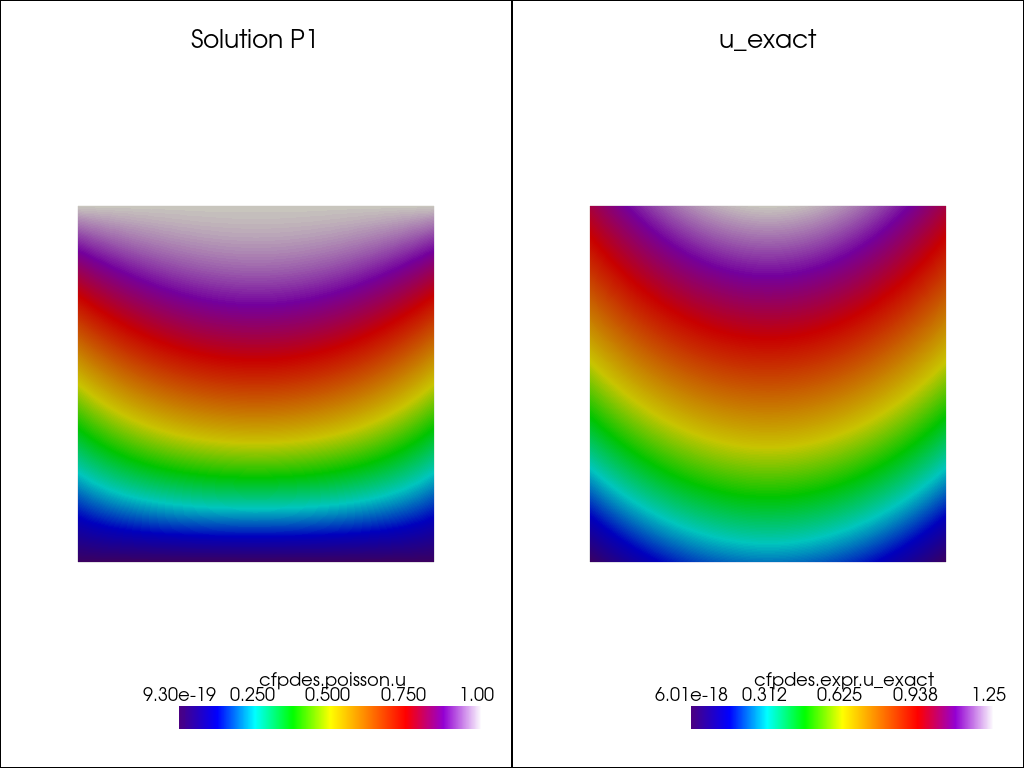

Solving the laplacian problem for h = 0.05...
generate mesh omega-2.geo with h=0.05 and dimension=2
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.05 
+------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                             |
+------------------------------------------------------------------------------------------------------------------------------------+
| +-----------------------------------------------------------------------------------------+                                        |
| | Environment                                                                             |                               

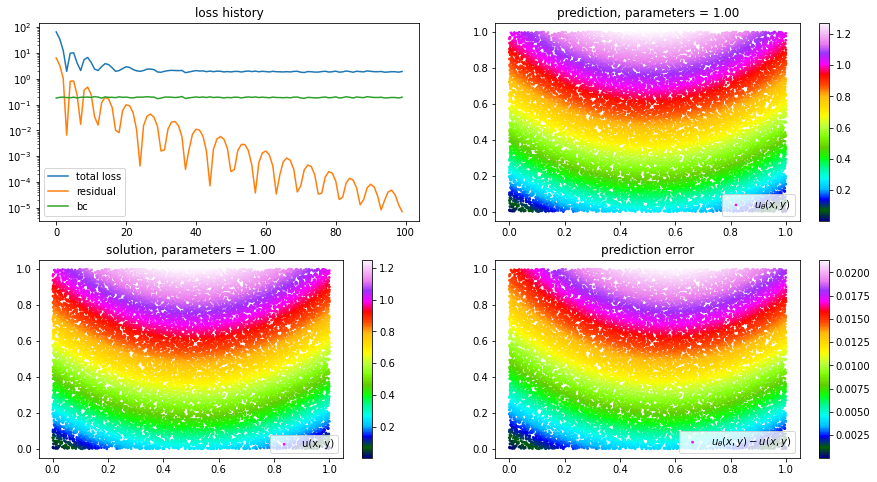

                          0
0  cfpdes.expr.grad_u_exact
1           cfpdes.expr.rhs
2       cfpdes.expr.u_exact
3          cfpdes.poisson.u
Number of features in coordinates: 3
Number of points: 517

Nodes: [[0.82477343 0.04606718]
 [0.8300841  0.10191753]
 [0.7806651  0.09123866]
 ...
 [0.8390992  0.3016979 ]
 [0.8367227  0.1427201 ]
 [0.7476512  0.5844005 ]]

Feel++ solution 'cfpdes.poisson.u':
[7.0988208e-02 1.4997619e-01 1.4220792e-01 3.1574559e-01 3.7043077e-01
 3.5161665e-01 6.9999999e-01 7.6717967e-01 7.0885134e-01 7.0600122e-01
 7.6692772e-01 6.9999999e-01 1.4764458e-01 5.9572354e-02 6.9223471e-02
 9.3805450e-01 9.3828136e-01 8.9906394e-01 2.9844701e-01 7.4903250e-02
 1.6373067e-01 1.5074378e-01 1.4785588e-01 2.2573152e-01 2.2389963e-01
 2.1297832e-01 1.3932036e-01 1.4802368e-01 1.5408097e-01 2.2201897e-01
 7.8854002e-02 8.9724857e-01 2.2339831e-01 1.5029952e-01 8.9858375e-02
 1.5524049e-01 7.8802779e-02 7.4960627e-02 1.4800759e-01 8.1012495e-02
 1.3613881e-01 6.8539441e-02 1.6

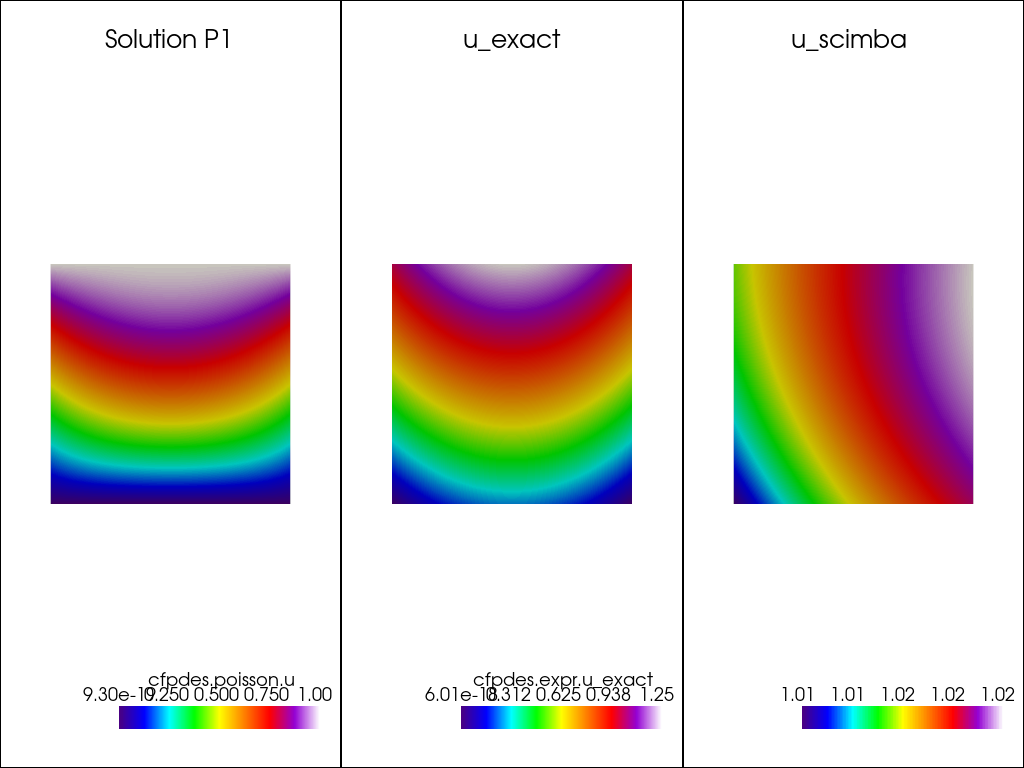

In [5]:

u_exact = 'y + (x*(1-x) + y*(1-y)/4) '
P(rhs='5/2', g='y', solver='feelpp', u_exact = u_exact)
P(rhs='5/2', g='y', solver ='scimba', u_exact = u_exact)


Solving the laplacian problem for h = 0.05...
generate mesh omega-2.geo with h=0.05 and dimension=2
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.05 
+----------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                 |
+----------------------------------------------------------------------------------------------------------------------------------------+
| +-----------------------------------------------------------------------------------------+                                            |
| | Environment                                                                             |               

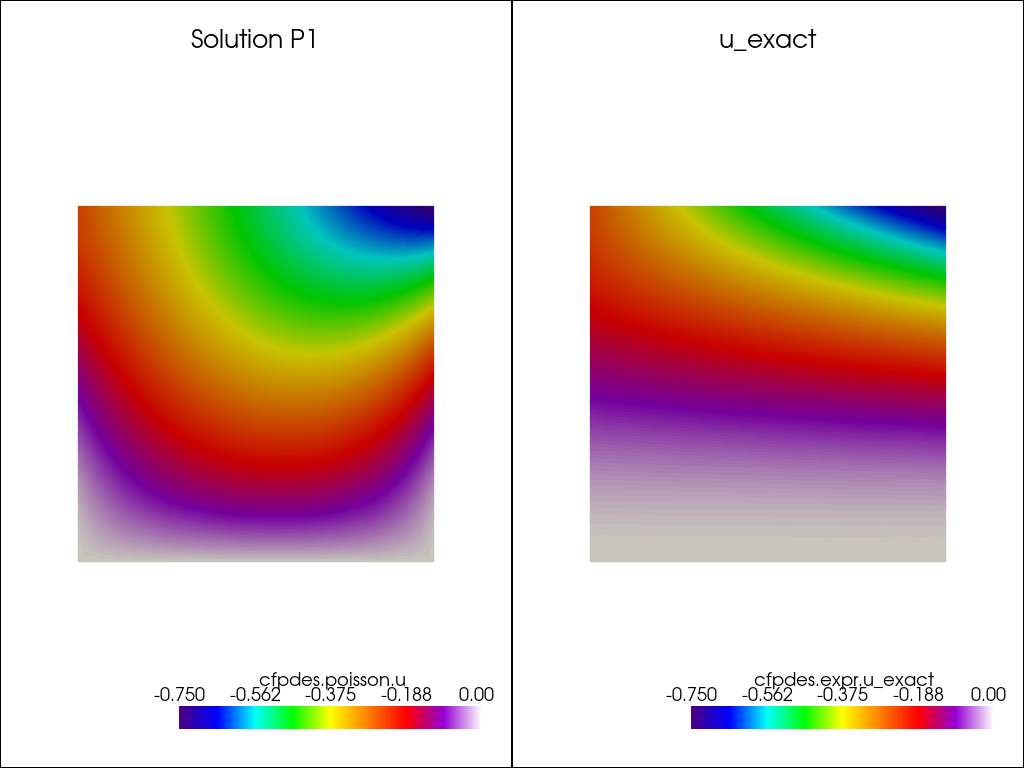

Solving the laplacian problem for h = 0.05...
generate mesh omega-2.geo with h=0.05 and dimension=2
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.05 
+----------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                 |
+----------------------------------------------------------------------------------------------------------------------------------------+
| +-----------------------------------------------------------------------------------------+                                            |
| | Environment                                                                             |               

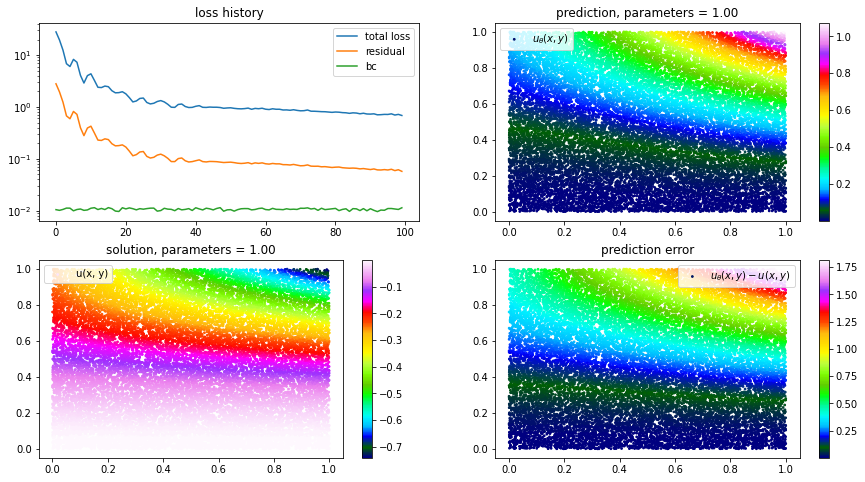

                          0
0  cfpdes.expr.grad_u_exact
1           cfpdes.expr.rhs
2       cfpdes.expr.u_exact
3          cfpdes.poisson.u
Number of features in coordinates: 3
Number of points: 517

Nodes: [[0.82477343 0.04606718]
 [0.8300841  0.10191753]
 [0.7806651  0.09123866]
 ...
 [0.8390992  0.3016979 ]
 [0.8367227  0.1427201 ]
 [0.7476512  0.5844005 ]]

Feel++ solution 'cfpdes.poisson.u':
[-2.64498238e-02 -5.57945222e-02 -5.69793358e-02 -7.39795193e-02
 -9.82561186e-02 -7.57460073e-02 -3.56474996e-01 -4.26003933e-01
 -3.64253730e-01 -1.98744908e-01 -2.21639171e-01 -1.84974998e-01
 -6.22208752e-02 -2.49725450e-02 -2.78016310e-02 -2.84572333e-01
 -2.62966275e-01 -2.57239461e-01 -5.54782450e-02 -3.22209261e-02
 -7.07055256e-02 -6.48537800e-02 -6.42815083e-02 -9.86301526e-02
 -9.63841677e-02 -8.04198757e-02 -5.25016487e-02 -5.83274774e-02
 -6.71686903e-02 -8.79090577e-02 -3.42861116e-02 -2.71326482e-01
 -9.42217931e-02 -6.35852367e-02 -3.72674614e-02 -6.30425811e-02
 -3.16371769e-0

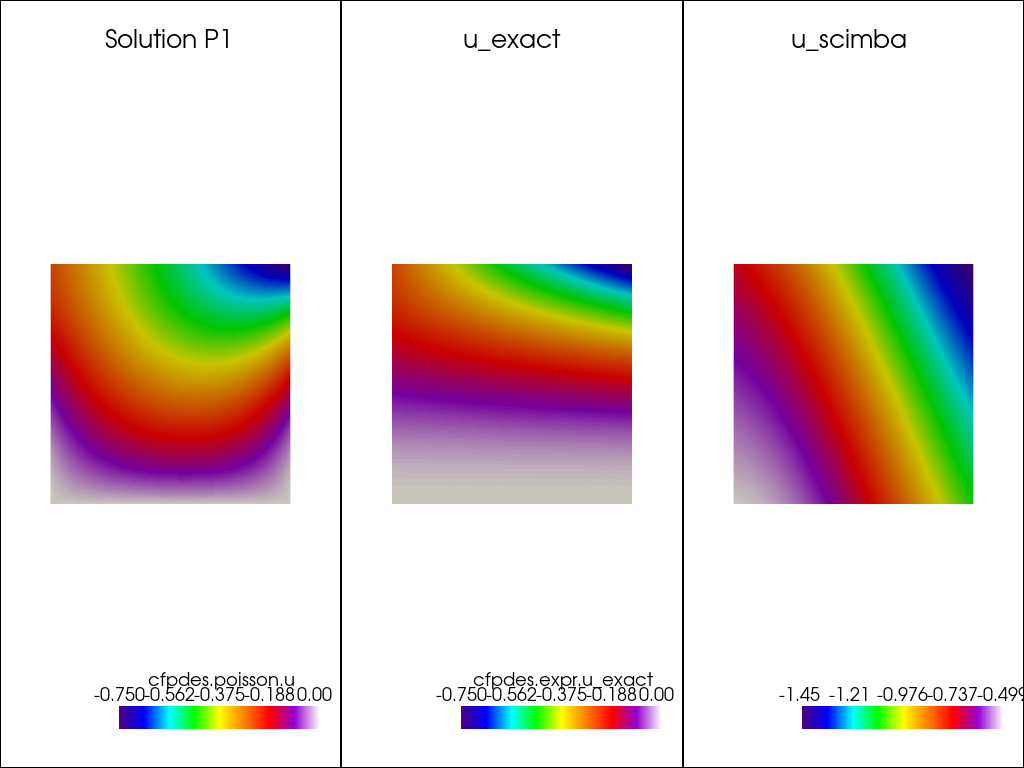

In [6]:

u_exact = '-y*y/2 - x*y*y*y/2 + y*y*y*y/4'
P( rhs='-1.0-3*y*x+y*y', g='-y*y/2 - x*y*y*y/2 + y*y*y*y/4', solver='feelpp', u_exact = u_exact)
P( rhs='-1.0-3*y*x+y*y', g='-y*y/2 - x*y*y*y/2 + y*y*y*y/4', solver ='scimba', u_exact = u_exact)

### Computing errors

In [7]:
# Collect data to compute errors
u_exact = 'sin(2*pi*x) * sin(2*pi*y)'
grad_u_exact = '{2*pi*cos(2*pi*x) * sin(2*pi*y), 2*pi*sin(2*pi*x) * cos(2*pi*y)}'
rhs = '8*pi*pi*sin(2*pi*x) * sin(2*pi*y)'

h= [0.1, 0.05, 0.025, 0.0125]
measures = []
"""
for i in h:
  P(h=i, rhs=rhs, g='0', plot = None, u_exact = u_exact)
  measures.append(P.measures)

print(measures)
"""
P(h=h[0], rhs=rhs, g='0', plot = None, u_exact = u_exact, grad_u_exact=grad_u_exact)
print('measures = ',P.measures)
measures.append(P.measures)


P(h=h[1], rhs=rhs, g='0', plot = None, u_exact = u_exact, grad_u_exact=grad_u_exact)
print('measures = ',P.measures)
measures.append(P.measures)

P(h=h[2], rhs=rhs, g='0', plot = None, u_exact = u_exact, grad_u_exact=grad_u_exact)
print('measures = ',P.measures)
measures.append(P.measures)

P(h=h[3], rhs=rhs, g='0', plot = None, u_exact = u_exact, grad_u_exact=grad_u_exact)
print('measures = ',P.measures)
measures.append(P.measures)

print('\n', measures)


# Plotting the error convergence rates
poisson_json = lambda order,dim=2,name="u": P.model
df= runConvergenceAnalysis( P, json=poisson_json, measures=measures, dim=2,verbose=True)
print('measures = ', measures)
fig= plot_convergence(P, df,dim=2)
fig.show()


Solving the laplacian problem for h = 0.1...
generate mesh omega-2.geo with h=0.1 and dimension=2
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.1 
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                                 |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| +-----------------------------------------------------------------------------------------+                                                            |
| | Environment                                

In [8]:
# Collect data to compute errors
u_exact = 'y + (x*(1-x) + y*(1-y)/4) '
grad_u_exact = '{1 - 2*x, (5 - 2*y)/4}'
rhs='5/2'

h= [0.1, 0.05, 0.025, 0.0125]
measures = []
"""
for i in h:
  P(h=i, rhs=rhs, g='y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)', plot = None, u_exact = u_exact)
  measures.append(P.measures)

print(measures)
"""
P(h=h[0], rhs=rhs, g='y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)', plot = None, u_exact = u_exact, grad_u_exact=grad_u_exact)
print('measures = ',P.measures)
measures.append(P.measures)


P(h=h[1], rhs=rhs, g='y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)', plot = None, u_exact = u_exact, grad_u_exact=grad_u_exact)
print('measures = ',P.measures)
measures.append(P.measures)

P(h=h[2], rhs=rhs, g='y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)', plot = None, u_exact = u_exact, grad_u_exact=grad_u_exact)
print('measures = ',P.measures)
measures.append(P.measures)

P(h=h[3], rhs=rhs, g='y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)', plot = None, u_exact = u_exact, grad_u_exact=grad_u_exact)
print('measures = ',P.measures)
measures.append(P.measures)

print('\n', measures)

# Plotting the error convergence rates

poisson_json = lambda order,dim=2,name="u": P.model
df= runConvergenceAnalysis( P, json=poisson_json, measures=measures, dim=2,verbose=True)
print('measures = ', measures)
fig= plot_convergence(P, df,dim=2)
fig.show()


Solving the laplacian problem for h = 0.1...
generate mesh omega-2.geo with h=0.1 and dimension=2
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.1 
+------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                             |
+------------------------------------------------------------------------------------------------------------------------------------+
| +-----------------------------------------------------------------------------------------+                                        |
| | Environment                                                                             |                                  

In [9]:
# Collect data to compute errors
u_exact = 'y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)'
grad_u_exact = '{-2*x*y*y + 6*x*y - 2*x*y*y*y + 6*x*y*y - 2*x*x*y*y + 6*x*x*y , -2*x*x*y + 6*x*x*y - 2*x*x*y*y + 6*x*x*y*y - 2*x*y*y + 6*x*y*y}'
rhs='-2 * (-6 + x * (2 - 6 * y) + 3 * y - 8 * y*y + 2 * y*y*y + x*x * (-2 + 6 * y))'

h= [0.1, 0.05, 0.025, 0.0125]
measures = []
"""
for i in h:
  P(h=i, rhs=rhs, g='y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)', plot = None, u_exact = u_exact)
  measures.append(P.measures)

print(measures)
"""
P(h=h[0], rhs=rhs, g='y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)', plot = None, u_exact = u_exact, grad_u_exact=grad_u_exact)
print('measures = ',P.measures)
measures.append(P.measures)


P(h=h[1], rhs=rhs, g='y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)', plot = None, u_exact = u_exact, grad_u_exact=grad_u_exact)
print('measures = ',P.measures)
measures.append(P.measures)

P(h=h[2], rhs=rhs, g='y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)', plot = None, u_exact = u_exact, grad_u_exact=grad_u_exact)
print('measures = ',P.measures)
measures.append(P.measures)

P(h=h[3], rhs=rhs, g='y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)', plot = None, u_exact = u_exact, grad_u_exact=grad_u_exact)
print('measures = ',P.measures)
measures.append(P.measures)

print('\n', measures)

# Plotting the error convergence rates

poisson_json = lambda order,dim=2,name="u": P.model
df= runConvergenceAnalysis( P, json=poisson_json, measures=measures, dim=2,verbose=True)
print('measures = ', measures)
fig= plot_convergence(P, df,dim=2)
fig.show()

Solving the laplacian problem for h = 0.1...
generate mesh omega-2.geo with h=0.1 and dimension=2
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.1 
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                                                  |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| +-----------------------------------------------------------------------------------------+                                                          

In [10]:

"""
# # 2D with varying anisotropy
P = Poisson(dim = 2)
u_exact = 'x*x/(1+x) + y*y/(1+y)'
P(rhs='4', diff='{1+x,0,0,1+y}', g='x*x/(1+x) + y*y/(1+y)', solver='feelpp', u_exact = u_exact)
P(rhs='4', diff='{1+x,0,0,1+y}', g='x*x/(1+x) + y*y/(1+y)', solver='scimba', u_exact = u_exact)

u_exact = 'x*x + y*y'
P(rhs='4', diff='{x,y,-y,x+y}', g='x*x + y*y',  solver='feelp', u_exact = u_exact)

poisson_json = lambda order,dim=2,name="u": P.model
print(poisson_json(dim=2,order=1))
df= runConvergenceAnalysis( P, json=poisson_json, measures=measures, dim=2,verbose=True)
print('measures = ', measures)
fig= plot_convergence(P, df,dim=2)
fig.show()
"""


'\n# # 2D with varying anisotropy\nP = Poisson(dim = 2)\nu_exact = \'x*x/(1+x) + y*y/(1+y)\'\nP(rhs=\'4\', diff=\'{1+x,0,0,1+y}\', g=\'x*x/(1+x) + y*y/(1+y)\', solver=\'feelpp\', u_exact = u_exact)\nP(rhs=\'4\', diff=\'{1+x,0,0,1+y}\', g=\'x*x/(1+x) + y*y/(1+y)\', solver=\'scimba\', u_exact = u_exact)\n\nu_exact = \'x*x + y*y\'\nP(rhs=\'4\', diff=\'{x,y,-y,x+y}\', g=\'x*x + y*y\',  solver=\'feelp\', u_exact = u_exact)\n\npoisson_json = lambda order,dim=2,name="u": P.model\nprint(poisson_json(dim=2,order=1))\ndf= runConvergenceAnalysis( P, json=poisson_json, measures=measures, dim=2,verbose=True)\nprint(\'measures = \', measures)\nfig= plot_convergence(P, df,dim=2)\nfig.show()\n'